In [1]:
import time
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import random

import sys
sys.path.append('../')
from cnn.commons import inc_convolution
from cnn.commons import inc_max_pool

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Theoretical and Eperical Speedups

In [2]:
batch_size = 128
in_channels = 128
in_size = 112
out_channels = in_channels
out_size = in_size
k_size = 3

conv = True

In [3]:

theoretical_speedup = []
emperical_speedup = []
best_achievable_speedup = []
cudnn_speedup = []

in_tensor = torch.FloatTensor(batch_size, in_channels,  in_size, in_size).random_(0, 10)
weights = torch.FloatTensor(out_channels, in_channels, k_size, k_size).random_(0, 10)
biases = torch.FloatTensor(out_channels).random_(0, 10)

in_tensor, weights, biases = in_tensor.cuda(), weights.cuda(), biases.cuda()

conv_module = torch.nn.Conv2d(in_channels, out_channels, k_size, padding=1, stride=1).cuda()
conv_module.weight.data = weights
conv_module.bias.data = biases
conv_module = torch.nn.Sequential(conv_module, torch.nn.ReLU(inplace=True))
max_pool_module = torch.nn.MaxPool2d(kernel_size=2, stride=2)

in_tensor, weights, biases = Variable(in_tensor), Variable(weights), Variable(biases)


#full inference
if conv:
    temp = conv_module(in_tensor)
else:
    temp = max_pool_module(in_tensor)
    
torch.cuda.synchronize()
prev_time = time.time()
for i in range(5):
    if conv:
        out_ptch = conv_module(in_tensor)
    else:
        out_ptch = max_pool_module(in_tensor)
    torch.cuda.synchronize()
torch.cuda.synchronize()
full_time = (time.time()-prev_time)/5/batch_size

x = range(1, in_size//2, k_size-1)
x_label = []

for p_size in x:
    
    #sanity check
    if p_size >= in_size:
        continue
    else:
        x_label.append(p_size)

    x_loc = [random.choice(range(0, in_size-p_size)) for _ in range(batch_size)]
    y_loc = [random.choice(range(0, in_size-p_size)) for _ in range(batch_size)]
    locations = torch.from_numpy(np.array(zip(x_loc, y_loc), dtype=np.int32))
    #locations = [(1,1), (1,5)]
    
    #patch size equvalient full inference
    in_tensor_prime = Variable(torch.FloatTensor(batch_size, in_channels,  p_size+(k_size-1), p_size+(k_size-1)).fill_(1.0).cuda())
    if conv:
        conv_module(in_tensor_prime)
    else:
        max_pool_module(in_tensor_prime)
        
    torch.cuda.synchronize()
    prev_time = time.time()
    for i in range(10):
        if conv:
            conv_module(in_tensor_prime)
        else:
            max_pool_module(in_tensor_prime)
        torch.cuda.synchronize()
    torch.cuda.synchronize()
    inc_best_time = (time.time()-prev_time)/10/batch_size
    
    #incremental inference
    patch_location_tensor = locations.cuda()
    if conv:
        inc_convolution(in_tensor.data, weights.data, biases.data, out_ptch.data, patch_location_tensor, 1, 1, p_height=p_size, p_width=p_size, beta=1.0)
    else:
        inc_max_pool(in_tensor, out_ptch, patch_location_tensor,
                    0, 2, 2, p_height=p_size, p_width=p_size)
    torch.cuda.synchronize()

    prev_time = time.time()
    for i in range(10):
        patch_location_tensor = locations.cuda()
        if conv:
            inc_convolution(in_tensor.data, weights.data, biases.data, out_ptch.data, patch_location_tensor, 1, 1, p_height=p_size, p_width=p_size, beta=1.0)
        else:
            inc_max_pool(in_tensor, out_ptch, patch_location_tensor,
                    0, 2, 2, p_height=p_size, p_width=p_size, version=1)

        torch.cuda.synchronize()
    torch.cuda.synchronize()
    empr_time = (time.time()-prev_time)/10/batch_size
    
    #_, output_size = inc_conv_module(in_tensor, weights, biases, out_ptch, patch_location_tensor, 1, 1, k_size, p_height=p_size, p_width=p_size, version=4)
    #print(output_size)
    
    theoretical_speedup.append(1.0*out_size*out_size/(p_size+k_size-1)**2)
    best_achievable_speedup.append(full_time/inc_best_time)
    emperical_speedup.append(full_time/empr_time)

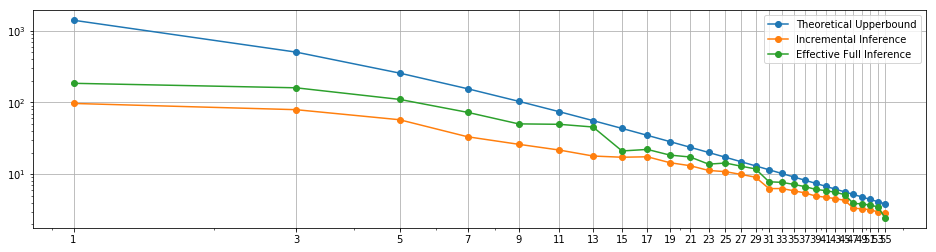

In [4]:
plt.rcParams["figure.figsize"] = (16,4)

plt.xscale('log')
plt.yscale('log')
plt.plot(x_label, theoretical_speedup, label='Theoretical Upperbound', marker='o')
plt.plot(x_label, emperical_speedup, label='Incremental Inference', marker='o')
plt.plot(x_label, best_achievable_speedup, label='Effective Full Inference', marker='o')
plt.xticks(x_label, x_label)
plt.legend()
plt.grid()
plt.show()

In [5]:
zip(x_label, theoretical_speedup, best_achievable_speedup, emperical_speedup)

[(1, 1393.7777777777778, 184.46765169989956, 96.68601503759398),
 (3, 501.76, 159.68260275673663, 79.16301403595173),
 (5, 256.0, 110.12451828380576, 57.34843687285376),
 (7, 154.8641975308642, 72.63465883416177, 33.19113130113827),
 (9, 103.6694214876033, 50.211792268645056, 26.0947665334118),
 (11, 74.22485207100591, 49.529099102569035, 21.697499409442173),
 (13, 55.75111111111111, 45.41333521683853, 17.90805910287298),
 (15, 43.40484429065744, 21.06414624557725, 17.225118546896347),
 (17, 34.74792243767313, 22.121901288513477, 17.475355031596113),
 (19, 28.444444444444443, 18.44597133963536, 14.458331459410838),
 (21, 23.71266540642722, 17.353900134952767, 13.122342976682484),
 (23, 20.0704, 13.802799364561418, 11.275781941899108),
 (25, 17.207133058984912, 14.300597190867538, 10.844998439779713),
 (27, 14.915576694411415, 12.926457579412947, 9.918732548632429),
 (29, 13.053069719042664, 11.842883719216811, 9.082153854846457),
 (31, 11.5188246097337, 7.834503094994395, 6.29503221132

In [6]:
np.sum(np.abs((temp-out_ptch).cpu().data.numpy().flatten()))

0.0

In [7]:
#temp
#out_ptch
#temp-out_ptch
#patch_location_tensor